In [1]:
import lib.dataset as dataset
from lib.evaluation import *
import models

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import tensorflow as tf
import pandas as pd
import numpy as np
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
# Read small datasets
train = 'copy_small-TRAIN.csv'
val = 'copy_small-VALIDATION.csv'
test = 'copy_small-TEST.csv'

In [4]:
# Prepare datasets
train_dataset, n_tr, y_true_train = dataset.create_dataset(train, categorical=False, batch_size=16, prefetch_buffer=2)

val_dataset, n_va, y_true_val = dataset.create_dataset(val, categorical=False, shuffle=False, augmentation=False)

test_dataset, n_te, y_true_test = dataset.create_dataset(test, categorical=False, shuffle=False, augmentation=False)

In [5]:
model = models.inceptionV3.get_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# Load weights if they were saved
save_path = 'saved_weights/custom_class_weights/model.h5'

if os.path.exists(save_path):
    model.load_weights(save_path)
    print('Model loaded')

In [6]:
## Another training
# With custom class weighs

class_weights = {0: 1, 1: 3}

In [7]:
# Compile
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
              metrics=['acc', 
                       tf.keras.metrics.AUC(summation_method='minoring')]) 
                       # 'minoring' applies left summation for increasing intervals and right summation for decreasing intervals

In [8]:
# Train
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, class_weight=class_weights)

Epoch 1/20
315/315 [==============================] - 105s 335ms/step - loss: 1.6009 - acc: 0.7377 - val_loss: 0.8729 - val_acc: 0.8271
Epoch 2/20
315/315 [==============================] - 107s 339ms/step - loss: 0.9876 - acc: 0.7500 - val_loss: 1.2606 - val_acc: 0.6500
Epoch 3/20
315/315 [==============================] - 106s 336ms/step - loss: 0.9742 - acc: 0.7524 - val_loss: 0.6291 - val_acc: 0.6896
Epoch 4/20
315/315 [==============================] - 106s 337ms/step - loss: 0.9481 - acc: 0.7367 - val_loss: 0.5589 - val_acc: 0.7958
Epoch 5/20
315/315 [==============================] - 106s 336ms/step - loss: 0.9038 - acc: 0.7641 - val_loss: 0.6979 - val_acc: 0.8000
Epoch 6/20
315/315 [==============================] - 106s 338ms/step - loss: 0.8437 - acc: 0.7845 - val_loss: 0.5895 - val_acc: 0.8458
Epoch 7/20
315/315 [==============================] - 106s 337ms/step - loss: 0.8258 - acc: 0.7942 - val_loss: 0.9983 - val_acc: 0.8458
Epoch 8/20
315/315 [============================

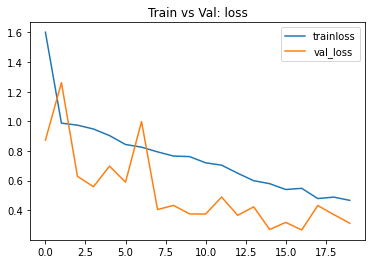

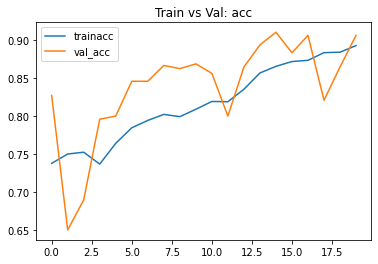

In [9]:
# Plot metrics
plot_metric(history, 'loss')
plot_metric(history, 'acc')
plot_metric(history, 'auc')

In [10]:
# Validation predictions
y_pred_val = model.predict(val_dataset).ravel()

# Test predictions
y_pred_test = model.predict(test_dataset).ravel()

In [13]:
# ROC curves for validation and test datasets
tpr_val, fpr_val, thresholds = get_roc_curve(y_true_val, y_pred_val)

tpr_test, fpr_test, thresholds = get_roc_curve(y_true_test, y_pred_test)

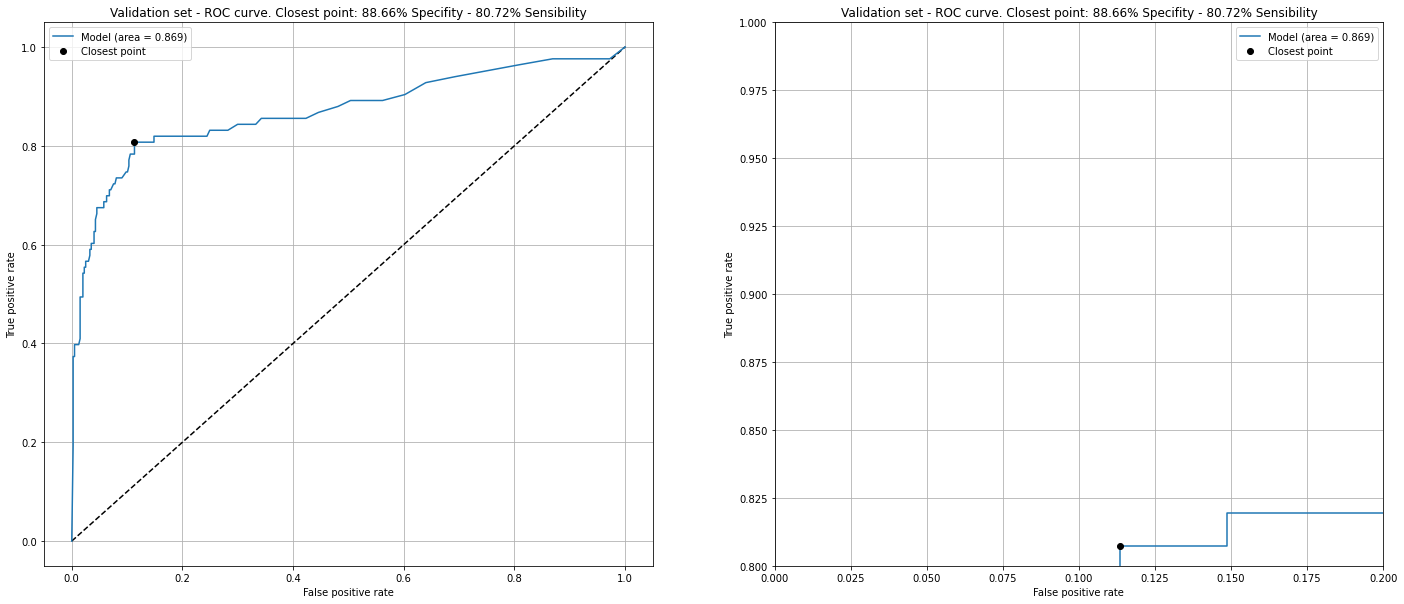

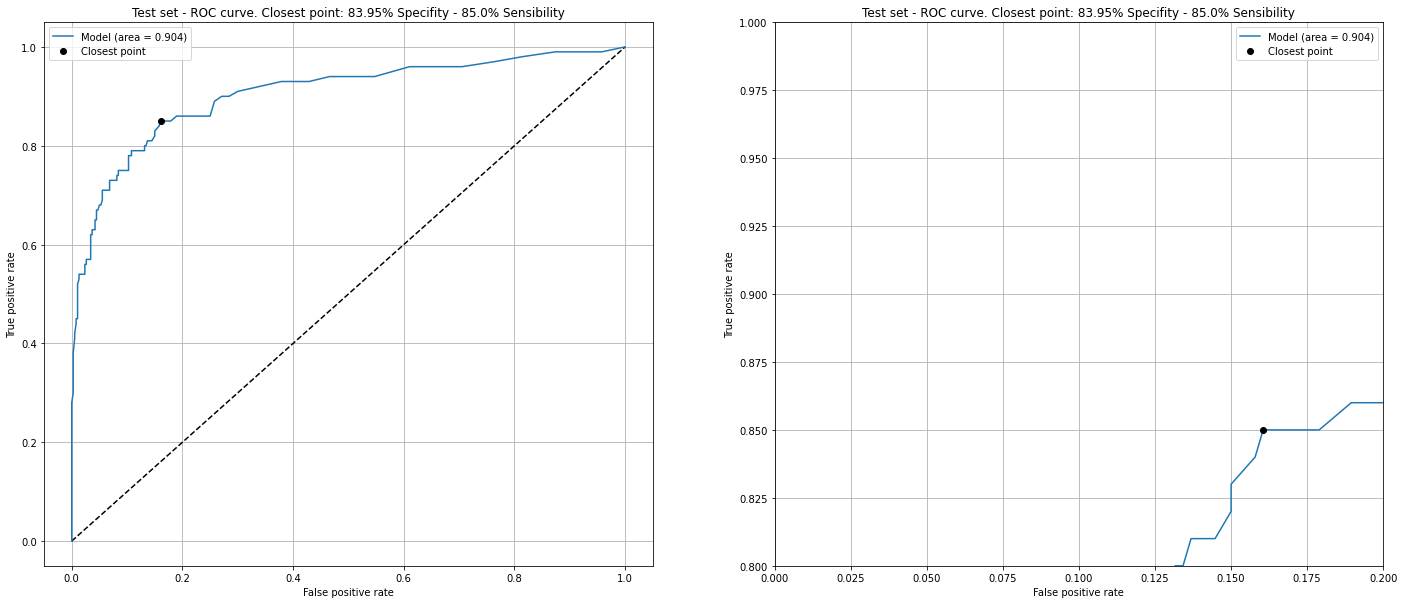

In [14]:
operating_threshold = plot_roc_curve(tpr_val, fpr_val, 'Model', 'Validation set', True)

plot_roc_curve(tpr_test, fpr_test, 'Model', 'Test set', True, operating_threshold)

In [ ]:
# Save model weights
model.save_weights(save_path)